=================================================

### Graded Challenge 7

Nama  : Nakia Melvana

Batch : RMT-026

**Program ini dibuat dengan tujuan untuk mengklasifikasi varietas beras putih menggunakan CNN Deep Leaning Model Sequential dan Transfer Learning InceptionV3**
=================================================

# Import Libraries

In [57]:
import os
import glob #using glob module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten

from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [2]:
!mkdir ~/.kaggle # Membuat direktori kaggle

!cp 'kaggle.json' ~/.kaggle #Menyalin file kaggle.json ke dalam direktori .kaggle
!ls ~/.kaggle #Menampilkan isi dari direktori .kaggle

kaggle.json


In [3]:
!chmod 600 /root/.kaggle/kaggle.json #Mengatur izin (permissions) dari file kaggle.json

In [4]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset # Download dataset dari kaggle

 98% 216M/219M [00:01<00:00, 212MB/s]
100% 219M/219M [00:01<00:00, 201MB/s]


In [5]:
!unzip -q /content/rice-image-dataset.zip -d images # unzip dataset yang telah di download

In [6]:
main_path= '/content/images/Rice_Image_Dataset'
os.listdir(main_path) #mengecek isi dir di dalam folder main_path

['Rice_Citation_Request.txt',
 'Basmati',
 'Ipsala',
 'Karacadag',
 'Arborio',
 'Jasmine']

**Insight:** isi dari main path dari file gambar dataset adalah 'Basmati',
 'Rice_Citation_Request.txt','Ipsala','Jasmine','Karacadag','Arborio',  sehingga memiliki 5 kelas yang akan masuk ke proses modelling. File yang tidak berkaitan dapat di delete.

In [7]:
num_samples_per_category = 1500 # mengambil 1500 data pada setiap kelas

# Mendefinisikan file setiap kelas
Arborio_files = glob.glob('/content/images/Rice_Image_Dataset/Arborio/*')[:num_samples_per_category]
Basmati_files = glob.glob('/content/images/Rice_Image_Dataset/Basmati/*')[:num_samples_per_category]
Ipsala_files = glob.glob('/content/images/Rice_Image_Dataset/Ipsala/*')[:num_samples_per_category]
Jasmine_files = glob.glob('/content/images/Rice_Image_Dataset/Jasmine/*')[:num_samples_per_category]
Karacadag_files = glob.glob('/content/images/Rice_Image_Dataset/Karacadag/*')[:num_samples_per_category]


**Menggabungkan setiap file setiap kelas kedalam satu dataset**

In [8]:
imgs = Arborio_files+Basmati_files+Ipsala_files+Jasmine_files+Karacadag_files
labels = ['Arborio' for i in range(len(Arborio_files))]+['Basmati' for i in range(len(Basmati_files))]+['Ipsala' for i in range(len(Ipsala_files))]+['Jasmine' for i in range(len(Jasmine_files))]+['Karacadag' for i in range(len(Karacadag_files))]
data = pd.DataFrame({'images':imgs,'label':labels})
data = data.sample(len(data)).reset_index(drop=True)

In [9]:
data.head()

,images,label
0,/content/images/Rice_Image_Dataset/Jasmine/Jas...,Jasmine
1,/content/images/Rice_Image_Dataset/Basmati/bas...,Basmati
2,/content/images/Rice_Image_Dataset/Karacadag/K...,Karacadag
3,/content/images/Rice_Image_Dataset/Jasmine/Jas...,Jasmine
4,/content/images/Rice_Image_Dataset/Jasmine/Jas...,Jasmine


**Insight:** dataframe yang dibuat merupakan data yang telah dipilih sebelumnya karena tidak semua data gambar digunakan dengan alasan akan memperlambat proses training dan memerlukan komputasi yang sangat besar sehingga total data berjumlah 7500 gambar dengan 1500 data pada setiap kelasnya.

**Menampilkan summary data**

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  7500 non-null   object
 1   label   7500 non-null   object
dtypes: object(2)
memory usage: 117.3+ KB


**Insight:** Images dan label bertipe data string dengan jumlah data sebanyak 7500 data. Dataframe yang telah dibentuk ini kemudian akan di save kedalam file csv.

In [11]:
data.to_csv('RiceDataset.csv', index = False) # save dataframe ke csv

# Exploratory Data Analysis (EDA)

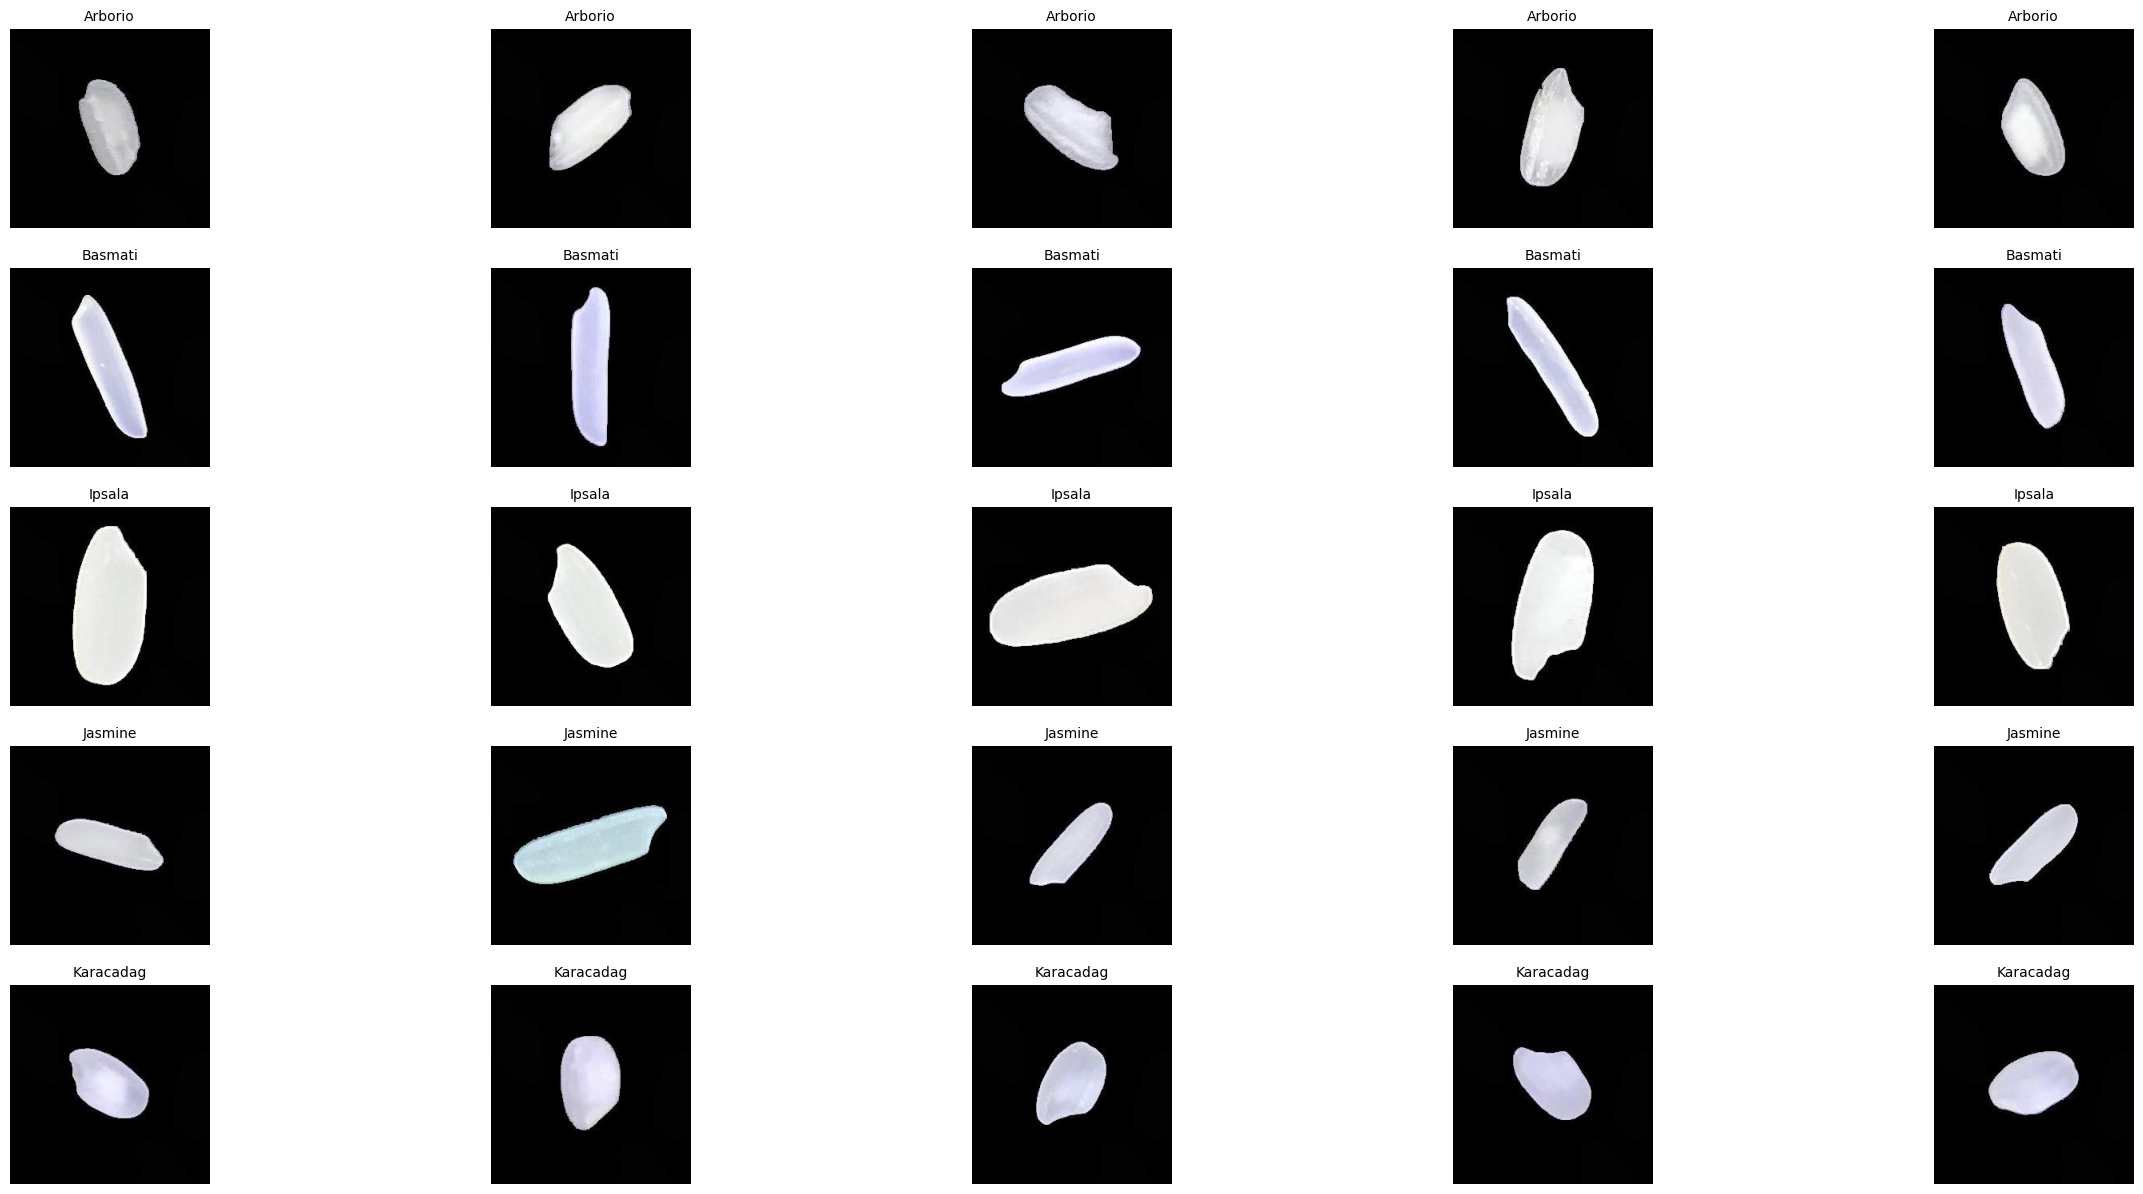

In [12]:
file_lists = [Arborio_files, Basmati_files, Ipsala_files, Jasmine_files, Karacadag_files] # mendefinisikan list file
class_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'] # mendefinisikan nama kelas

# mendefinisikan fig dan axes untuk menampilkan gambar masing-masing kelas 5 gambar
fig, axes = plt.subplots(nrows=len(file_lists), ncols=min(5, max(len(files) for files in file_lists)), figsize=(30, 3 * len(file_lists)))

# membuat forloop untuk list file
for row, files in enumerate(file_lists):
    for col in range(min(5, len(files))):
        img = plt.imread(files[col])
        axes[row, col].imshow(img)
        axes[row, col].axis('off')  # menghilangkan axis
        axes[row, col].set_title(f'{class_names[row]}', fontsize=10)  # mendisplay nama gambar

# menampilkan gambar
plt.show()

**Insight:** Berdasarkan visualisasi sample pada setiap kelas terdapat beberapa insight yang didapatkan:

1. setiap kelas memiliki karakteristik visual yang berbeda:
  - Arborio: memiliki bulir beras yang lebih transparan, cukup lebar, dan agak berwarna kuning.
  - Basmati: memiliki bulir beras yang cukup transparan, bentuknya cenderung lebih ramping, dan warnyanya lebih putih dibandingkan dengan arborio.
  - Ipsala: memiliki bulir beras yang tidak transparan, lebih lebar dibandingkan dengan arborio, dan warnanya agak kekuningan.
  - Jasmine: memiliki bulir beras yang ramping tetapi tidak seramping Basmati, tidak transparan, dan memiliki warna yang putih.
  - Karacadag : memiliki bulir beras yang lebar dan pendek cenderung bulat, berwarna putih, dan cukup transparan.
jika dilihat dari karakteristik setiap kelas, setiap kelas memiliki karakteristik yang cukup berbeda sehingga hal ini merupakan hal baik karena model lebih dapat dengan mudah untuk mengklasifikasikan gambar pada setiap kelas.

2. dilihat dari sample yang diambil, angle gambar cukup berbeda-beda dan tidak seragam. Hal ini cukup bagus dikarenakan memberikan peluang model untuk lebih belajar banyak dengan variasi sample yang banyak sehingga dapat berpeluang menghasilkan nilai akurasi yang baik.

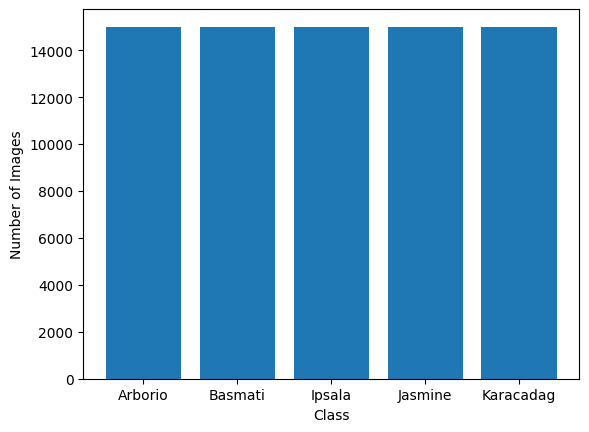

In [13]:
# menghitung jumlah data pada setiap kelas
class_counts = {class_name: len(os.listdir(f"/content/images/Rice_Image_Dataset/{class_name}")) for class_name in class_names}

# plot distribusi kelas
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

**Insight:** Terlihat dari distribusi setiap kelas pada dataset original, jumlah pada setiap kelas adalah 15000 data. Jika kita menggunakan semuanya pada setiap kelas, total data akan berjumlah 75000 data. Hal ini tidak baik karena komputasi yang dibutuhkan sangat besar dan pastinya waktu untuk training modelnya sangat lama. Karena tidak memungkinkan untuk training semua sample, maka sample yang digunakan pada pemodelan ini hanya mengambil 1500 sample pada setiap kelas yang menghasilkan 7500 total data yaitu 10 kali lebih sedikit dibandingkan dengan dataset originalnya. 

Image size: 250 x 250


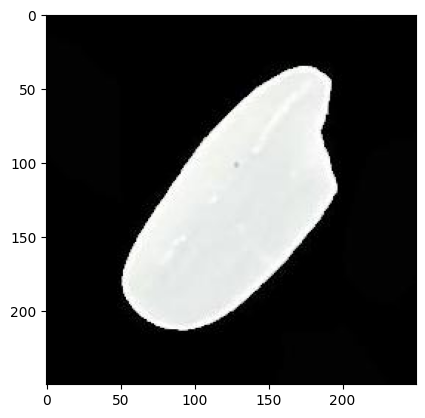

In [14]:
# membuka gambar
img_path = "/content/images/Rice_Image_Dataset/Ipsala/Ipsala (2644).jpg"
img = Image.open(img_path)

# mendapatkan ukuran gambar
width, height = img.size
print(f"Image size: {width} x {height}")

# Display gambar
plt.imshow(img)
plt.axis('on')
plt.show()


**Insight:** terlihat dari data yang ditampilkan bahwa ukuran gambar pada dataset adalah sebesar 250x250, hal ini kemudian akan mempengaruhi pada hasil pemodelan bagian input layer harus menggunakan ukuran 250x250, kecuali jika ingin melakukan resize gambar dengan ukuran tertentu. Selanjutnya perlu di cek apakah semua gambar memiliki ukuran gambar yang sama.

In [15]:
# load dataset
df = "RiceDataset.csv"  # Update with the actual path to your dataset
df = pd.read_csv(df)

# mendefinisikan variable untuk mendeteksi adanya ukuran gambar yang mismatch
size_mismatch_found = False
# variable untuk menyimpan ukuran referensi
reference_width, reference_height = None, None

# looping pada baris dataframe
for index, row in df.iterrows():
    img_path = row['images']
    # buka gambar
    img = Image.open(img_path)
    # mendapatkan ukuran gambar
    width, height = img.size

    # set gambar pertama sebagai ukuran referensi
    if reference_width is None and reference_height is None:
        reference_width, reference_height = width, height

    # membandingkan ukuran gambar lain dengan ukuran gambar referensi
    if width != reference_width or height != reference_height:
        size_mismatch_found = True
        break

# Print hasil
if size_mismatch_found:
    print(f"At least one image in the dataset has a different size.")
else:
    print("All images in the dataset have the same size.")

All images in the dataset have the same size.


**Insight:** Semua gambar memiliki ukuran gambar yang sama sehingga dapat masuk ke proses berikutnya dan tidak perlu dilakukan seleksi

Colorspace: RGB


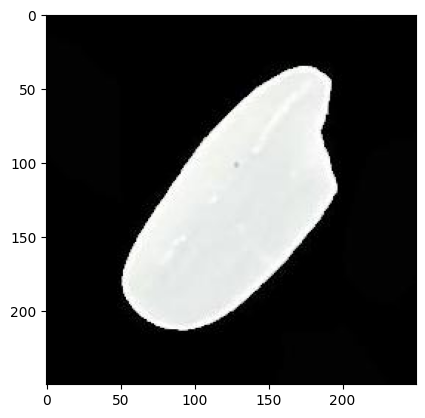

In [16]:
# membuka gambar
img_path = "/content/images/Rice_Image_Dataset/Ipsala/Ipsala (2644).jpg"
img = Image.open(img_path)

# mendapatkan colorspace pada sample data
colorspace = img.mode
print(f"Colorspace: {colorspace}")

# Convert ke RGB untuk display menggunakan matplotlib
img_rgb = img.convert('RGB')

# Display gambar
plt.imshow(img_rgb)
plt.axis('on')
plt.show()


**Insight:** gambar pada sample yang cek memiliki colorspace berwarna RGB sehingga memiliki jumlah channel sebanyak 3 channel. Hal ini perlu di cek karena mempengaruhi ukuran pada input layer proses training.

In [18]:
# mendefinisikan path dataset gambar
root_dir = "/content/images/Rice_Image_Dataset/"

# list nama kelas
class_names = os.listdir(root_dir)

# banyaknya sample yang perlu di check setiap kelas
num_samples = 30000

# menginisialisasi reference colorspace
reference_colorspace = None

# looping setiap kelas each class
for class_name in class_names:
    class_dir = os.path.join(root_dir, class_name)
    images = os.listdir(class_dir)
    sample_images = images[:num_samples]

    # looping pada sampled images
    for image_name in sample_images:
        img_path = os.path.join(class_dir, image_name)

        # membuka image
        img = Image.open(img_path)

        # mendapatkan colorspace
        current_colorspace = img.mode

        # mendefinsiikan colorspace pada gambar pertama dan menjadikan reference colorspace
        if reference_colorspace is None:
            reference_colorspace = current_colorspace

        # membandingkan colorspace lainnya dengan colorspace reference
        if current_colorspace != reference_colorspace:
            print(f"Colorspace mismatch in class '{class_name}' for image '{image_name}': Expected colorspace {reference_colorspace}, Actual colorspace {current_colorspace}")

# menampilkan hasilnya
if reference_colorspace is not None:
    print(f"All images have the same colorspace: {reference_colorspace}")
else:
    print("No images found.")

All images have the same colorspace: RGB


**Insigth:** Semua gambar dataset memiliki colorspace RGB sehingga dapat masuk ke proses berikutnya.

# Splitting Dataset

In [19]:
# mendefinisikan X dan y
x = data['images']
y = data['label']

# split data menjadi train set, val set, dan test set
x_train,x_test1,y_train,y_test1 = train_test_split(x,y,test_size=0.3,shuffle=True,random_state=64)
x_val, x_test, y_val, y_test  = train_test_split(x_test1,y_test1,test_size=0.5,shuffle=True,random_state=64)

print(f'x_train:{x_train.shape}')
print(f'x_test:{x_test.shape}')
print(f'x_val:{x_val.shape}')
print('')
print(f'y_train:{y_train.shape}')
print(f'y_test:{y_test.shape}')
print(f'y_val:{y_val.shape}')

x_train:(5250,)
x_test:(1125,)
x_val:(1125,)

y_train:(5250,)
y_test:(1125,)
y_val:(1125,)


**Insight:** data dari X dan y di split ke 3 data yaitu data train, validasi, dan test. Jumlah data pada dataset train adalah 5250, sedangkan pada dataset test dan val adalah 1125. Dengan ratio pembagian adalah 70% training, 15% masing-masing untuk validasi dan testing.

**Membuat dataframe untuk setiap dataset train, val, dan test**

In [20]:
train_df = pd.DataFrame({'image':x_train,'label':y_train})
test_df = pd.DataFrame({'image':x_test,'label':y_test})
validation_df = pd.DataFrame({'image':x_val,'label':y_val})

print(f'train_df:{train_df.shape}')
print(f'test_df:{test_df.shape}')
print(f'validation_df:{validation_df.shape}')

train_df:(5250, 2)
test_df:(1125, 2)
validation_df:(1125, 2)


**Insight:** Dataframe pada train, test, dan val adalah masing-masing (5250, 2), (1125, 2), dan (1125, 2)

# Preprocessing

**Mendefinisikan ukuran gambar, batch size, dan melakukan preprocessing pada gambar untuk memperbanyak variasi gambar sehingga model dapat belajar dengan variasi yang beragam dan meningkatkan performa dari model**

In [21]:
# mendefinsiikan ukuran gambar sebagai target ukuran dengan tujuan untuk resize
img_size = 224
# mendefinisikan bacth size
batch_size = 64
# melakukan proses variasi gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             zoom_range=0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.1,
                             rotation_range=30,
                             horizontal_flip=True)

In [22]:
train_gen = datagen.flow_from_dataframe(train_df,x_col='image',y_col='label',
                                        target_size=(img_size,img_size),
                                       batch_size=batch_size,shuffle=True,class_mode='categorical')

test_gen = datagen.flow_from_dataframe(test_df,x_col='image',y_col='label',
                                        target_size=(img_size,img_size),
                                       batch_size=batch_size,shuffle=False,class_mode='categorical')

val_gen = datagen.flow_from_dataframe(validation_df,x_col='image',y_col='label',
                                        target_size=(img_size,img_size),
                                       batch_size=batch_size,shuffle=True,class_mode='categorical')

Found 5250 validated image filenames belonging to 5 classes.
Found 1125 validated image filenames belonging to 5 classes.
Found 1125 validated image filenames belonging to 5 classes.


**Insight:** isi dari dataset train_gen, test_gen, dan val_gen merupakan dataset yang telah di resize ukurannya menjadi 224x224 dan ditentukan batchsize nya sebesar 64. Selain itu, dataset yang ada dilakukan proses menggunakan image data generator yang bertujuan agar dataset yang ada memiliki variasi yang lebih banyak dan model dapat mempelajari gambar dengan lebih baik.

**Cek indeks kelas**

In [23]:
for batch in train_gen:
    images, labels = batch
    print('label:', train_gen.class_indices)
    break  # Print only the first batch

label: {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


In [59]:
for batch in test_gen:
    images, labels = batch
    print('label:', test_gen.class_indices)
    break  # Print only the first batch

label: {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


In [60]:
for batch in val_gen:
    images, labels = batch
    print('label:', val_gen.class_indices)
    break  # Print only the first batch

label: {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


**Insight:** Pada setiap dataset, setiap kelas memiliki nilai encoded nya sendiri yang mana 'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4.

# ANN Training (Sequential & Functional API)

## Model Definition

In [26]:
# Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [27]:
# Create Sequential API
# mendefinisikan model sequential
model_sequential = Sequential()

# Hidden layer 1
model_sequential.add(Conv2D(32, (3,3),activation='relu', input_shape=(img_size, img_size, 3)))
model_sequential.add(MaxPooling2D(2, 2))

# Hidden layer 2
model_sequential.add(Conv2D(64, (3,3), activation='relu'))
model_sequential.add(MaxPooling2D(2, 2))
model_sequential.add(Dropout(0.5))

# output layer
model_sequential.add(Flatten())
model_sequential.add(Dense(128, activation='relu'))
model_sequential.add(Dense(5, activation='softmax'))

# Compile model
model_sequential.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


model_sequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 54, 54, 64)        0         
                                                                 
 flatten (Flatten)           (None, 186624)            0

**Insight:** dari model yang telah dibangun, menghasilkan jumlah parameter sebanyak 23908037. Jumlah parameter ini cukup besar dan dapat merepresentasikan kompleksitas dari sebuah model yang dibangun. Semakin besar parameter, maka kompleksitas dari model lebih tinggi.  

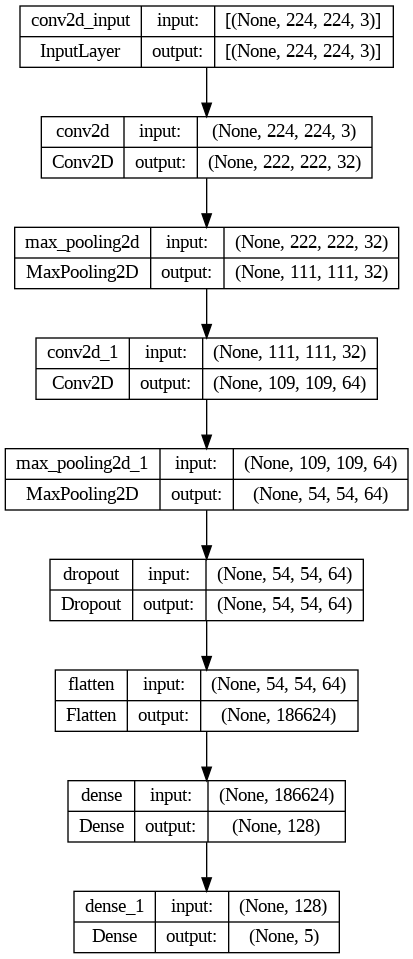

In [28]:
# Plot layers
tf.keras.utils.plot_model(model_sequential, show_shapes=True)

**Insight:** Model yang dirancang memiliki arsitektur input layer, dua hidden layer, dan output layer. Ukuran input layer merupakan 224,224,3, yang mana 224 merupakan ukuran gambar yang telah di resize menjadi 224 dan 3 merupakan jumlah channel dari gambar RGB.

Hidden layer pertama menggunakan jumlah filter sebanyak 32 dengan ukuran kernel sebesar 3x3 menggunakan aktivasi RELU yang mana dilanjutkan dengan layer maxpooling setelah layer konvolusi pertama. Maxpooling ini berguna untuk  mengurangi dimensi spasial gambar dan mempertahankan fitur yang paling dominan.

Selanjutnya hidden layer kedua menggunakan jumlah filter sebanyak 64, ukuran kernel 3x3 dan menggunakan fungsi aktivasi RELU yang mana juga dilanjutlan dengan layer maxpooling setelah layer konvolusi kedua. Selanjutnya menambahkan layer dropout dengan tingkat dropout sebesar 0.5. Dropout digunakan sebagai metode regularisasi untuk mencegah overfitting.

Lalu, menambahkan layer flatten untuk meratakan tensor menjadi vektor. Setelah dilakukan flatten menambahkan layer dense dengan 128 unit dan dilanjutkan dengan layer output dengan 5 unit sesuai dengan jumlah kelas.

pada layer output digunakan softmax dikarenakan klasifikasi merupakan klasifikasi multiclass yang mana lebih cocok untuk menggunakan softmax guna menghasilkan performa model yang lebih baik.

## Model Training

In [29]:
earlystop = EarlyStopping(patience=3) # menggunakan earlystop pada saat training
reduce_learning_rate = ReduceLROnPlateau(monitor="val_accuracy",
                                         patience=2, verbose=1,
                                         factor=0.5,  min_lr=0.00001) # menggunakan reduce_learning_rate pada keadaan yang telah didefinisikan

callbacks = [earlystop,reduce_learning_rate] # mendefinisikan callback

In [30]:
epochs = 100 # mendefinisikan maks epoch
# melakukan training model
history1 = model_sequential.fit(train_gen,
                                epochs=epochs,
                                steps_per_epoch=20,
                                validation_data = val_gen,
                                callbacks=callbacks,
                                verbose = 1,
                                validation_steps=10)

Epoch 1/100
20/20 [==============================] - 36s 2s/step - loss: 1.8746 - accuracy: 0.2734 - val_loss: 1.5321 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 41s 2s/step - loss: 1.4704 - accuracy: 0.3268 - val_loss: 1.4017 - val_accuracy: 0.3609 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 36s 2s/step - loss: 1.3795 - accuracy: 0.3941 - val_loss: 1.2547 - val_accuracy: 0.4594 - lr: 0.0010
Epoch 4/100
20/20 [==============================] - 28s 1s/step - loss: 1.1280 - accuracy: 0.5133 - val_loss: 1.0038 - val_accuracy: 0.5797 - lr: 0.0010
Epoch 5/100
20/20 [==============================] - 28s 1s/step - loss: 0.9475 - accuracy: 0.6125 - val_loss: 0.9444 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 6/100
20/20 [==============================] - 36s 2s/step - loss: 0.9310 - accuracy: 0.6010 - val_loss: 0.7942 - val_accuracy: 0.6984 - lr: 0.0010
Epoch 7/100
20/20 [==============================] - 28s 1s/step - loss: 0.7

**Insight:** Dari arsitektur sequential yang telah dibuat, hasil dari akurasinya menunjukkan performa yang baik dan mengalami konvergen pada epoch ke 17. Walaupun akurasi pada epoch pertama tidak terlalu baik yaitu sebesar 27%, tetapi setiap epoch mengalami kenaikan akurasi yang cukup banyak. Hal ini kemudian bisa ditingkatkan lagi dengan melakukan trial dan eror pada jumlah kernel, filter, dan hidden layer pada arsitektur. Secara garis besar, jika dilihat dari proses trainingnya, model ini cukup baik dalam melakukan klasifikasi.

## Model Evaluation

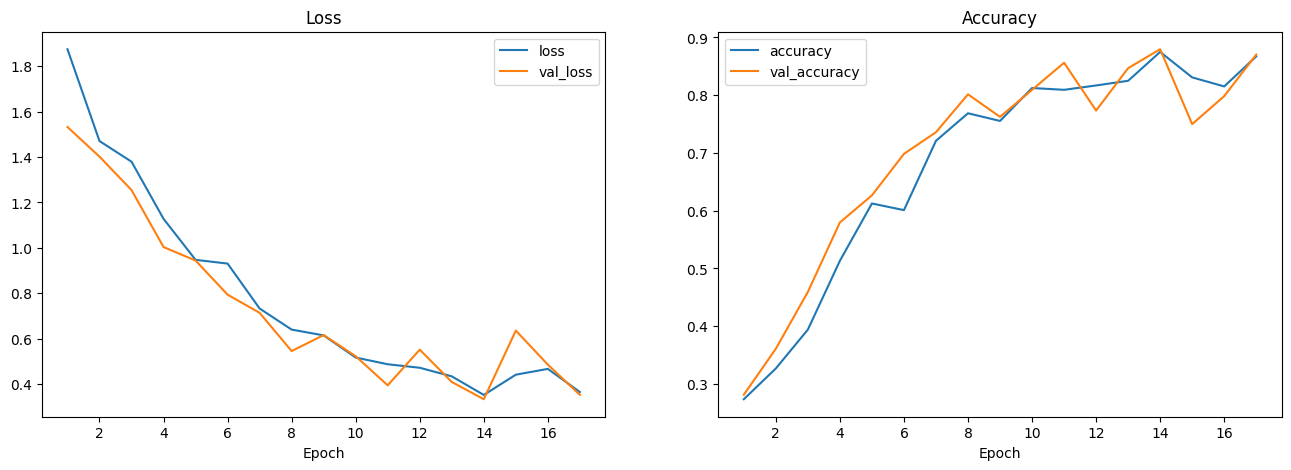

In [33]:
epoch=17 # mendefinsiikan jumlah epoch sesuai dengan training

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history1.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history1.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1,epoch+1),history1.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history1.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()

**Insight:** Hasil grafik loss dan accuracy pada model menunjukkan model mengalami goodfit yang ditunjukkan bahwa loss, val_loss, Accuracy, dan val_accuracy tidak memiliki gap pada kedua plot grafik. Tetapi pada prosesnya, nilainya tidak terlalu stabil, hal ini dapat ditingkatkan dengan menggunakan batch normalization agar model nya dapat lebih stabil.

In [34]:
test_results = model_sequential.evaluate(test_gen, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.3309
Test Accuracy : 0.8836


**Insight:** Nilai test loss nya adalah 0,33 dan nilai test Accuracy nya adalah 88%. Hal ini menunjukkan performa model yang cukup baik.

**Save Model**

In [35]:
model_sequential.save("model_training_ANN.h5")

**Melakukan prediksi nilai menggunakan model yang telah di train**

In [40]:
predictions = model_sequential.predict(test_gen)
y_pred = np.argmax(predictions,axis=1)
y_test =test_gen.classes
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)

df = pd.DataFrame({'Actual':y_test,'Prediction':y_pred})
df.head()

18/18 [==============================] - 17s 933ms/step


,Actual,Prediction
0,4,4
1,3,4
2,4,4
3,0,0
4,1,3


**Insight:** Dilakukan prediksi model menggunakan dataset aktualnya adalah y_test yang mana hasil prediksi nya adalah y_pred. Dilihat dari dataframe terdapat beberapa kelas yang masih mengalami misklasifikasi seperti kelas 1 (Basmati) yang misklasifikasi pada kelas 3 (Jasmine). Untuk melihat jumlah miklasifikasi yang jelas, dapat digunakan confusion matrix.

<Axes: >

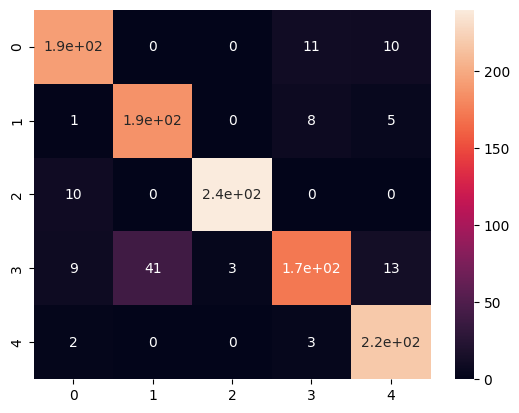

In [41]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)

**Insight:** Pada confusion matrix, terlihat bahwa misklasifikasi paling banyak terjadi pada kelas 3 yang misklasifikai dengan kelas 1, selanjutnya diikuti oleh kelas 3 yang misklasifikasi di kelas 4. Dari hasil ini, diasumsikan bahwa model masih belum dapat dengan optimal membedakan karakterisik beras jasmine dengan beras basmati dan memang jika dilihat dari analisis visual, kedua beras tersebut memiliki visual yang mirip.

In [38]:
classificationReport = classification_report(y_test,y_pred)
print(f'Classification Report : {classificationReport}')

Classification Report :               precision    recall  f1-score   support

           0       0.93      0.87      0.90       214
           1       0.78      0.91      0.84       200
           2       0.98      0.99      0.99       250
           3       0.83      0.67      0.74       238
           4       0.89      0.99      0.94       223

    accuracy                           0.89      1125
   macro avg       0.88      0.89      0.88      1125
weighted avg       0.89      0.89      0.88      1125



**Insight:** Berdasarkan classification report, nilai akurasi dari keseluruhannya adalah 89% dengan nilai macro avg precision adalah 88%, recall adalah 89%, dan f1-score adalah 88%. Hasil dari report ini menunjukkan performa klasifikasi model yang cukup baik.

# ANN Improvement (Sequential API & Functional API)

## Training using InceptionV3

In [42]:
inputs = (224,224,3) # mendefinisikan ukuran input
pretrained_model = tf.keras.applications.InceptionV3(include_top=False, weights = 'imagenet', 
                                                  input_shape=inputs,pooling='avg')
pretrained_model.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


**Insight:** Menggunakan transfer learning model inceptionV3 dengan bobot yang digunakan adalah hasil dari training imagenet. Transfer learning digunakan agar waktu dan komputasi yang dibutuhkan lebih sedikit dibandingkan dengan tidak menggunakan transfer learning karena model tidak perlu menghitung ulang bobot.

Alasan penggunaan InceptionV3 sebagai transfer learning:
Penggunaan model ini didasari oleh paper Budiono et al. yang menyatakan bahwa model inception ini memiliki keunggulan pada inception module nya yang mana menghasilkan proses feature extraction secara efisien pada skala yang beragam. Hal ini mengakibatkan model yang dapat dengan baik meng-*capture* patterns di skala yang berbeda. Selain itu, menggunakan tranfer learning dengan bobot imagenet yang telah di train dengan dataset dengan skala yang besar memberikan peluang untuk menghasilkan akurasi yang baik pada dataset yang lebih kecil dengan hasil yang lebih akurat dan proses yang lebih cepat.



(LINK PAPER: https://www.researchgate.net/publication/375130720_CLASSIFICATION_OF_RICE_TEXTURE_BASED_ON_RICE_IMAGE_USED_THE_CONVOLUTIONAL_NEURAL_NETWORK_METHOD)

In [43]:
model_tf= Sequential()
model_tf.add(pretrained_model)

#fully connected layer
model_tf.add(Flatten())
model_tf.add(Dense(128, activation='relu')),
model_tf.add(Dense(units=5,activation='Softmax'))

In [44]:
model_tf.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [45]:
model_tf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 22065701 (84.17 MB)
Trainable params: 262917 (1.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


**Insight:** dari model yang telah dibangun, menghasilkan jumlah parameter sebanyak 22065701. Jumlah parameter ini cukup besar dan dapat merepresentasikan kompleksitas dari sebuah model yang dibangun. Semakin besar parameter, maka kompleksitas dari model lebih tinggi. Jumlah parameter dari transfer learning adalah 21802784 yang direpresentasikan pada non-traninable params, dan total trainable paramsnya adalah 262917. Dari total params ini lebih sedikit dibandingkan dengan ANN Training model yang dibuat sebelumnya berarti model ini kompleksitasnya lebih rendah dibandingkan dengan model sequential yang dirancang sebelumnya.

## Model Training

In [58]:
earlystop = EarlyStopping(patience=3)# menggunakan earlystop pada saat training
reduce_learning_rate = ReduceLROnPlateau(monitor="val_accuracy",
                                         patience=2, verbose=1,
                                         factor=0.5,  min_lr=0.00001) # menggunakan reduce_learning_rate pada keadaan yang telah didefinisikan


callbacks = [earlystop,reduce_learning_rate] # mendefinisikan callback

In [47]:
epochs = 100 # mendefinisikan maks epoch
# melakukan training model
history2 = model_tf.fit_generator(train_gen,epochs=epochs,validation_data=val_gen,callbacks=callbacks)

Epoch 1/100
83/83 [==============================] - 112s 1s/step - loss: 0.1477 - accuracy: 0.8773 - val_loss: 0.0850 - val_accuracy: 0.9342 - lr: 0.0010
Epoch 2/100
83/83 [==============================] - 109s 1s/step - loss: 0.0709 - accuracy: 0.9480 - val_loss: 0.0867 - val_accuracy: 0.9316 - lr: 0.0010
Epoch 3/100
83/83 [==============================] - 108s 1s/step - loss: 0.0608 - accuracy: 0.9524 - val_loss: 0.0616 - val_accuracy: 0.9476 - lr: 0.0010
Epoch 4/100
83/83 [==============================] - 109s 1s/step - loss: 0.0486 - accuracy: 0.9585 - val_loss: 0.0605 - val_accuracy: 0.9484 - lr: 0.0010
Epoch 5/100
83/83 [==============================] - 109s 1s/step - loss: 0.0515 - accuracy: 0.9581 - val_loss: 0.0512 - val_accuracy: 0.9564 - lr: 0.0010
Epoch 6/100
83/83 [==============================] - 110s 1s/step - loss: 0.0386 - accuracy: 0.9690 - val_loss: 0.0397 - val_accuracy: 0.9716 - lr: 0.0010
Epoch 7/100
83/83 [==============================] - 97s 1s/step - los

**Insight:** Jika dilihat dari proses training, hasil akhir akurasi yang didapat adalah 96% yang mana ini menghasilkan nilai yang sangat baik walaupun model telah mengalami konvergen pada epoch ke 9. Jika dibandingkan dengan model sebelumnya, training menggunakan model inceptionV3 ini mengalami konvergen yang lebih cepat dan nilai akurasinya juga yang jauh lebih baik. Jika dilihat dari epoch pertama juga akurasi yang dihasilkan sudah tinggi yaitu pada nilai 87%.

In [48]:
# save model
model_tf.save("model_InceptionV3.h5")

## Model Evaluation

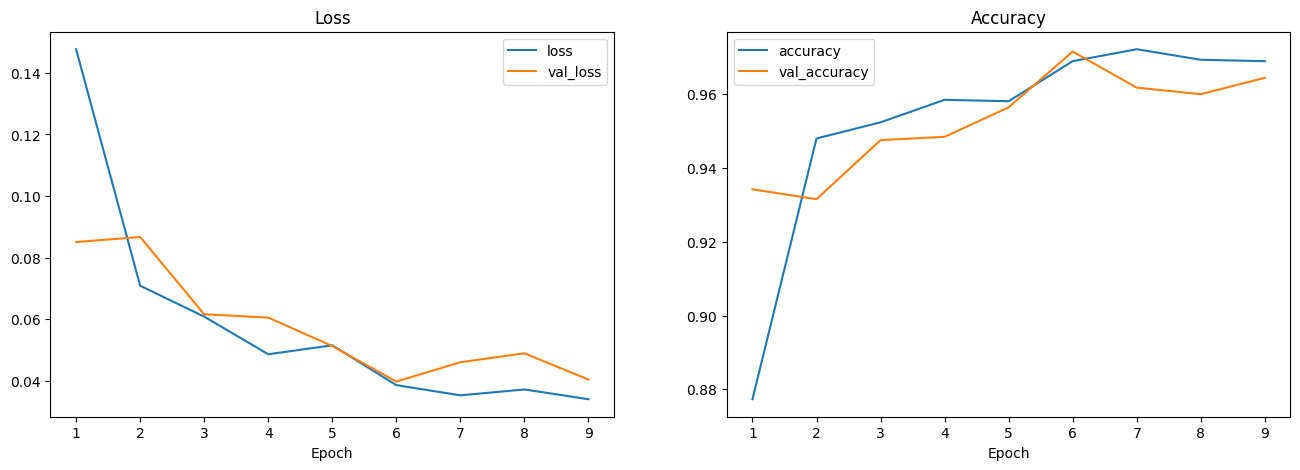

In [49]:
epoch=9 # mendefinsiikan jumlah epoch sesuai dengan training

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history2.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history2.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1,epoch+1),history2.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history2.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()

**Insight:** Berdasarkan dari grafik plot yang dihasilkan pada grafil loss dan accuracy menunjukkan performa model yang goodfit. Walaupun, loss, val_loss, accuracy, dan val_accuracy memiliki gap, tetapi gapnya tidak terlalu besar dan masih bisa dikatakan sebagai goodfit. proses dari modelling tidak terlalu stabil, hal ini bisa ditingkatkan dengan menambahkan batch normalization atau dengan melakukan partial transfer learning sehingga dapat ditingkatkan performanya pada arsitektur inceptionV3 nya.

In [50]:
test_results = model_tf.evaluate(test_gen, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.0401
Test Accuracy : 0.9636


**Insight:** Hasil dari test loss sebesar 0.04 dan test accuracy sebesar 96%. Hasil yang didapatkan lebih baik dibandingkan dengan hasil dari model sequential sebelumnya yaitu nilai loss nya yang lebih kecil dan test accuracy nya yang jauh lebih besar.

In [51]:
predictions = model_tf.predict(test_gen)
y_pred = np.argmax(predictions,axis=1)
y_test =test_gen.classes
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)

df = pd.DataFrame({'Actual':y_test,'Prediction':y_pred})
df.head()

18/18 [==============================] - 21s 1s/step


,Actual,Prediction
0,4,4
1,3,3
2,4,4
3,0,0
4,1,1


**Insight:** Dilakukan prediksi model dengan menggunakan dataset y_test dengan hasil predictionnya adalah y_pred. jika dilihat sekilas pada dataframe, hasil dari prediksi nya cukup akurat dan memiliki misklasifikasi yang sedikit. untuk meninjau lebih spesifik dapat ditampilkan confusion matrixnya.

<Axes: >

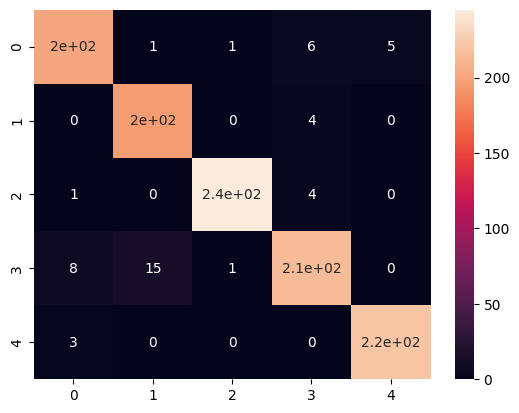

In [52]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)

**Insight:** terlihat pada confusion matrix banyak kelas yang tidak mengalami misklasifikasi, tetapi masih ada juga kelas yang mengalami misklasifikasi, yaitu kelas 3 yang misklasifikasi dengan kelas 1 sebanyak 15. Walaupun begitu, misklasifikasi ini sudah berkurang jika dibandingkan dengan model sebelumnya. Artinya, model ini lebih unggul dibandingkan dengan model sequential yang dirancang.

In [53]:
classificationReport = classification_report(y_test,y_pred)
print(f'Classification Report : {classificationReport}')

Classification Report :               precision    recall  f1-score   support

           0       0.94      0.94      0.94       214
           1       0.92      0.98      0.95       200
           2       0.99      0.98      0.99       250
           3       0.94      0.90      0.92       238
           4       0.98      0.99      0.98       223

    accuracy                           0.96      1125
   macro avg       0.96      0.96      0.96      1125
weighted avg       0.96      0.96      0.96      1125



**Insight:** Berdasarkan classification report, nilai akurasi dari keseluruhannya adalah 96% dengan nilai macro avg precision adalah 96%, recall adalah 96%, dan f1-score adalah 96%. Hasil dari report ini menunjukkan performa klasifikasi model yang sangat baik dan lebih baik dibandingkan dengan model sequential.  

# Kesimpulan

Terdapat beberapa kesimpulan yang dapat diambil dari proses prediksi varietas beras putih:
- model improvement telah berhasil dirancang dengan menggunakan tranfer learning inceptionV3 dengan bobot imagenet yang menghasilkan akurasi 96% dan performa model yang goodfit. kelebihan dari model ini adalah proses training yang lebih sedikit karena proses telah mengalami konvergen pada epoch ke 9 tetapi kekurangannya adalah karena yang digunakan adalah full transfer learning, maka tidak bisa mendefinisikan hyperparameter untuk improve model.
- model ANN training dirancang menggunakan sequential API yang menghasilkan nilai akurasi tidak lebih baik dibandingkan dengan model improvement yaitu sebesar 88%. Walaupun begitu, kelebihan dari model ini adalah dapat di definisikan hyperparameter nya sehingga dapat dilakukan trial dan eror untuk mencapai hasil yang maksimal.
- Hasil yang lebih baik dapat dicapai dengan melakukan beberapa cara, yaitu melakukan partial transfer learning sehingga sebagian layer pada layer inceptionV3 dapat di modifikasi dan menghasilkan hasil yang lebih fit pada dataset yang digunakan. Selain itu dapat di-improve dengan mencoba arsitektur model lain yang berpeluang untuk menghasilkan performa yang lebih baik seperti resnet karena resnet memiliki beberapa macam dengan jumlah layer yang berbeda sehingga dapat di modifikasi dan disesuaikan dengan dataset.